In [6]:
import sys
import matplotlib.pyplot as plt
sys.path.append('../')
from compressor.core import compressor, show_img
def compute_path(name):
    return '../img/' + name + '.jpg'

In [8]:
i1 = compressor(compute_path('lena'), rank=2, im_type='gray', compressor_type='SVD', verbose=True)
i2 = compressor(compute_path('lena'), rank=2, im_type='gray', compressor_type='SVD', verbose=True)


Image processing...

Rank: 2 SVD shape: (512, 2) (2,) (2, 512)

Image processing...

Rank: 2 SVD shape: (512, 2) (2,) (2, 512)


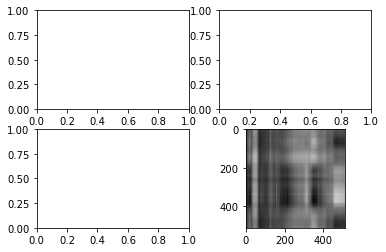

In [9]:
f, axarr = plt.subplots(2,2)
axarr[0,0] = plt.imshow(i1)
axarr[0,1] = plt.imshow(i2)
plt.show()